In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import io
import os
from PIL import Image

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt

In [3]:
DATAPATH = 'images/'

In [16]:
def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret, img = cv2.threshold(blur,70,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    img = cv2.resize(img, (img.shape[0]//2, img.shape[1]//2))
    return img

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
def show_image(a,save=False,save_fname=None):
    ''' display the image using matplotlib'''
    plt.figure(figsize=(8,6))
    a = np.uint8(np.clip(a, 0, 255))
    plt.imshow(a)
    plt.show()
    if save:
        if save_fname is None:
            raise ValueError('save_fname must be set if save=True')
        plt.imsave(save_fname,a)

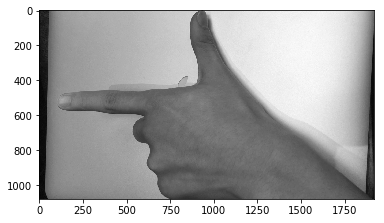

In [17]:
test = cv2.imread(DATAPATH + 'L/frame770.jpg')
test = cv2.cvtColor(test,cv2.COLOR_BGR2GRAY)
plt.imshow(test, cmap="gray")
plt.show()

(1080, 1920)
(1080, 1920)


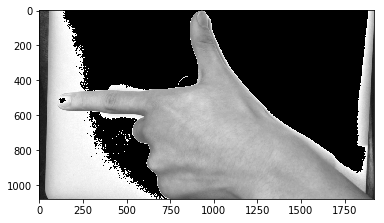

In [39]:
blur = cv2.GaussianBlur(test,(5,5),0)
print(blur.shape)
ret, thresh1 = cv2.threshold(blur,70,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU+cv2.THRESH_TOZERO)
print(thresh1.shape)
plt.imshow(thresh1, cmap="gray")
plt.show()

contours, hierarchy = cv2.findContours(thresh1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
for i in range(len(contours)):
    cnt=contours[i]
    area = cv2.contourArea(cnt)
    if(area>max_area):
        max_area=area
        ci=i
    cnt=contours[ci]
hull = cv2.convexHull(cnt)
drawing = np.zeros(img.shape,np.uint8)
cv2.drawContours(drawing,[cnt],0,(0,255,0),2)
cv2.drawContours(drawing,[hull],0,(0,0,255),2)

In [19]:
data = []
labels = []
label_index = 0 

for label in os.listdir(DATAPATH):
    if label == 'ok' or label == 'rock':
        img_dir = DATAPATH + label + '/'
        for fn in os.listdir(img_dir):
            img = cv2.imread(img_dir + fn, 1)
            img = preprocess(img)
            data.append(img)
            labels.append(label_index)
        label_index += 1    

print("Finished loading data")

Finished loading data


In [20]:
data = np.array(data)
labels = np.array(labels)

In [21]:
np.save('data3.npy', data)
np.save('labels3.npy', labels)

In [5]:
data = np.load('data2.npy')
labels = np.load('labels2.npy')

In [6]:
# data = data[:len(data)//4]
# labels = labels[:len(labels)//4]

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=6)

In [23]:
batch_size = 128
num_classes = 2
epochs = 12
channels = 1
# input image dimensions
img_rows, img_cols = 360, 640

# the data, split between train and test sets

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], channels, img_rows, img_cols)
    input_shape = (channels, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
    input_shape = (img_rows, img_cols, channels)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (1600, 360, 640, 1)
1600 train samples
400 test samples


In [29]:
model = Sequential()
model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [28]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 1600 samples, validate on 400 samples
Epoch 1/12


InvalidArgumentError: BiasGrad requires tensor size <= int32 max
	 [[Node: training_1/Adadelta/gradients/conv2d_3/BiasAdd_grad/BiasAddGrad = BiasAddGrad[T=DT_FLOAT, _class=["loc:@conv2d_3/BiasAdd"], data_format="NHWC", _device="/job:localhost/replica:0/task:0/cpu:0"](training_1/Adadelta/gradients/conv2d_3/Relu_grad/ReluGrad)]]

Caused by op 'training_1/Adadelta/gradients/conv2d_3/BiasAdd_grad/BiasAddGrad', defined at:
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-157097d4eaf4>", line 9, in <module>
    validation_data=(x_test, y_test))
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/keras/models.py", line 960, in fit
    validation_steps=validation_steps)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/keras/engine/training.py", line 1634, in fit
    self._make_train_function()
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/keras/engine/training.py", line 990, in _make_train_function
    loss=self.total_loss)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/keras/optimizers.py", line 344, in get_updates
    grads = self.get_gradients(loss, params)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/keras/optimizers.py", line 73, in get_gradients
    grads = K.gradients(loss, params)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2394, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 542, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 348, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 542, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/tensorflow/python/ops/nn_grad.py", line 259, in _BiasAddGrad
    data_format=data_format))
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 311, in bias_add_grad
    data_format=data_format, name=name)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'conv2d_3/BiasAdd', defined at:
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 18 identical lines from previous traceback]
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-658d6c17cec1>", line 4, in <module>
    input_shape=input_shape))
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/keras/models.py", line 464, in add
    layer(x)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/keras/engine/topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/keras/layers/convolutional.py", line 178, in call
    data_format=self.data_format)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 3574, in bias_add
    data_format='NHWC')
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 1292, in bias_add
    return gen_nn_ops._bias_add(value, bias, data_format=data_format, name=name)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 281, in _bias_add
    data_format=data_format, name=name)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/alexchan/anaconda3/envs/MLKart/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): BiasGrad requires tensor size <= int32 max
	 [[Node: training_1/Adadelta/gradients/conv2d_3/BiasAdd_grad/BiasAddGrad = BiasAddGrad[T=DT_FLOAT, _class=["loc:@conv2d_3/BiasAdd"], data_format="NHWC", _device="/job:localhost/replica:0/task:0/cpu:0"](training_1/Adadelta/gradients/conv2d_3/Relu_grad/ReluGrad)]]


In [ ]:
with open("results.txt", "w") as f:
    f.write(score)

In [ ]:
model.save("model_0.h5")